-------- > epoch 1:  coût moyen entraînement = 0.847038209438324
-------- > epoch 1:  taux moyen entraînement = 0.7183195352554321
-------- > epoch 1:  coût moyen validation = 0.5895611047744751
-------- > epoch 1:  taux moyen validation = 0.7978000044822693
-------- > epoch 2:  coût moyen entraînement = 0.5425161123275757
-------- > epoch 2:  taux moyen entraînement = 0.8108193874359131
-------- > epoch 2:  coût moyen validation = 0.5060733556747437
-------- > epoch 2:  taux moyen validation = 0.8215001821517944
-------- > epoch 3:  coût moyen entraînement = 0.49163147807121277
-------- > epoch 3:  taux moyen entraînement = 0.8289794921875
-------- > epoch 3:  coût moyen validation = 0.48321619629859924
-------- > epoch 3:  taux moyen validation = 0.8314999938011169
-------- > epoch 4:  coût moyen entraînement = 0.4630507826805115
-------- > epoch 4:  taux moyen entraînement = 0.8392394781112671
-------- > epoch 4:  coût moyen validation = 0.45203086733818054
-------- > epoch 4:  taux

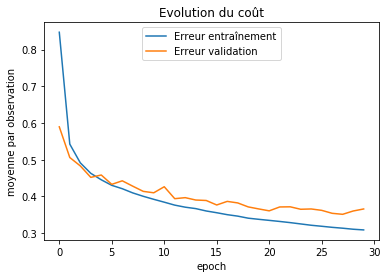

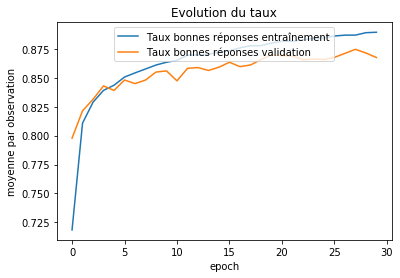

In [13]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple simple de MNIST avec PyTorch
Exemple avec nn.Sequential et F.cross_entropy
Production de métriques avec graphes
Fonction entrainer
"""
import torch
torch.manual_seed(0) # Pour résultats reproductibles

# Fonction J d'entropie croisée
import torch.nn.functional as F
fonction_cout = F.cross_entropy

def taux_bonnes_predictions(lot_Y_predictions, lot_Y):
    predictions_categorie = torch.argmax(lot_Y_predictions, dim=1)
    return (predictions_categorie == lot_Y).float().mean()

from torch import nn
# Définition de l'architecture du RNA
modele = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)
    
from torch import optim
optimiseur = optim.SGD(modele.parameters(), lr=0.05)

import torchvision
import torchvision.transforms as transforms

#Chargement des données
ds = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
ds_ent, ds_valid = torch.utils.data.random_split(ds, [50000, 10000])
ds_test = torchvision.datasets.MNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())
ds_test = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

#Création du DataLoader avec le dataset
dl_ent = torch.utils.data.DataLoader(ds_ent, batch_size=100, shuffle = True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=100)

def entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10):

    # Listes pour les métriques par epoch
    liste_cout_moyen_ent = []
    liste_taux_moyen_ent = []
    liste_cout_moyen_valid = []
    liste_taux_moyen_valid = []
    
    # Boucle d'apprentissage
    for epoch in range(nb_epochs):
        cout_total_ent = 0 # pour cumuler les couts par mini-lot
        taux_bonnes_predictions_ent = 0 # pour cumuler les taux par mini-lot
        modele.train() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        
        # Boucle d'apprentissage par mini-lot pour une epoch
        for lot_X, lot_Y in dl_ent:
            optimiseur.zero_grad() # Remettre les dérivées à zéro
            lot_Y_predictions = modele(lot_X) # Appel de la méthode forward
            cout = fonction_cout(lot_Y_predictions, lot_Y)
            cout.backward() # Calcul des gradiants par rétropropagation
            with torch.no_grad():
                cout_total_ent +=cout
                taux_bonnes_predictions_ent += taux_bonnes_predictions(lot_Y_predictions, lot_Y)
            optimiseur.step() # Mise à jour des paramètres
        # Calculer les moyennes par mini-lot
        with torch.no_grad():
            cout_moyen_ent = cout_total_ent/len(dl_ent)
            taux_moyen_ent = taux_bonnes_predictions_ent/len(dl_ent)
       
        modele.eval() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        with torch.no_grad():
            cout_valid = sum(fonction_cout(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
            taux_bons_valid = sum(taux_bonnes_predictions(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
        cout_moyen_valid = cout_valid/len(dl_valid)
        taux_moyen_valid = taux_bons_valid/len(dl_valid)
        print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  taux moyen entraînement = {taux_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  coût moyen validation = {cout_moyen_valid}')
        print(f'-------- > epoch {epoch+1}:  taux moyen validation = {taux_moyen_valid}')
    
        liste_cout_moyen_ent.append(cout_moyen_ent)
        liste_taux_moyen_ent.append(taux_moyen_ent)
        liste_cout_moyen_valid.append(cout_moyen_valid)
        liste_taux_moyen_valid.append(taux_moyen_valid)
    
    # Affichage du graphique d'évolution des métriques par epoch
    import numpy as np
    import matplotlib.pyplot as plt
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_valid,label='Erreur validation')
    plt.title("Evolution du coût")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
        
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_ent,label='Taux bonnes réponses entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_valid,label='Taux bonnes réponses validation')
    plt.title("Evolution du taux")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()

entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=30)

In [12]:
entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10)

KeyboardInterrupt: 

-------- > epoch 1:  coût moyen entraînement = 0.08183100074529648
-------- > epoch 1:  taux moyen entraînement = 0.9772604703903198
-------- > epoch 1:  coût moyen validation = 0.11893507093191147
-------- > epoch 1:  taux moyen validation = 0.9661003351211548
-------- > epoch 2:  coût moyen entraînement = 0.08116219937801361
-------- > epoch 2:  taux moyen entraînement = 0.977920651435852
-------- > epoch 2:  coût moyen validation = 0.11896507441997528
-------- > epoch 2:  taux moyen validation = 0.9655002355575562
-------- > epoch 3:  coût moyen entraînement = 0.0808834433555603
-------- > epoch 3:  taux moyen entraînement = 0.9777202606201172
-------- > epoch 3:  coût moyen validation = 0.1190396249294281
-------- > epoch 3:  taux moyen validation = 0.9662003517150879
-------- > epoch 4:  coût moyen entraînement = 0.08071591705083847
-------- > epoch 4:  taux moyen entraînement = 0.9778199791908264
-------- > epoch 4:  coût moyen validation = 0.1189088523387909
-------- > epoch 4: 

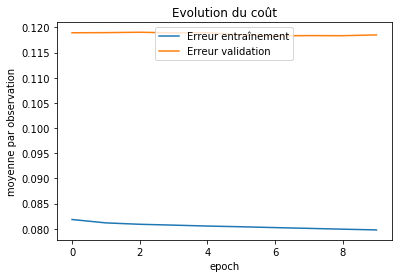

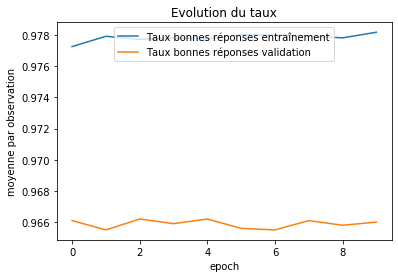

In [9]:
optimiseur = optim.SGD(modele.parameters(), lr=0.005)
entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10)

In [13]:
CHEMIN = './MNISTSimple10.pth'
torch.save(modele.state_dict(), CHEMIN)

-------- > epoch 1:  coût moyen entraînement = 0.07819783687591553
-------- > epoch 1:  taux moyen entraînement = 0.9786808490753174
-------- > epoch 1:  coût moyen validation = 0.11802491545677185
-------- > epoch 1:  taux moyen validation = 0.9660003781318665
-------- > epoch 2:  coût moyen entraînement = 0.07803085446357727
-------- > epoch 2:  taux moyen entraînement = 0.9788404107093811
-------- > epoch 2:  coût moyen validation = 0.11803194880485535
-------- > epoch 2:  taux moyen validation = 0.9664003252983093
-------- > epoch 3:  coût moyen entraînement = 0.07789315283298492
-------- > epoch 3:  taux moyen entraînement = 0.9786200523376465
-------- > epoch 3:  coût moyen validation = 0.11738929152488708
-------- > epoch 3:  taux moyen validation = 0.9660001993179321
-------- > epoch 4:  coût moyen entraînement = 0.07770983129739761
-------- > epoch 4:  taux moyen entraînement = 0.9788204431533813
-------- > epoch 4:  coût moyen validation = 0.11744580417871475
-------- > epoch

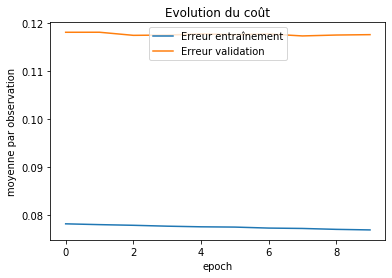

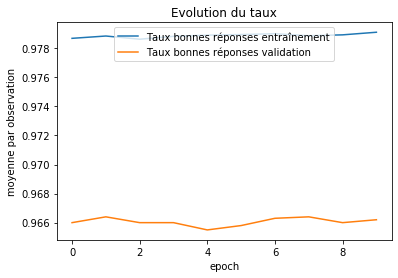

In [14]:
modele.load_state_dict(torch.load(CHEMIN))
entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10)

In [15]:
ds_test = TensorDataset(donnees_test_X,donnees_test_Y)
dl_test = DataLoader(ds_test, batch_size=100)
with torch.no_grad():
    cout_test = sum(fonction_cout(modele(lot_test_X), lot_test_Y) for lot_test_X, lot_test_Y in dl_test)
    taux_bons_test = sum(taux_bonnes_predictions(modele(lot_test_X), lot_test_Y) for lot_test_X, lot_test_Y in dl_test)
cout_moyen_test = cout_test/len(dl_test)
taux_moyen_test = taux_bons_test/len(dl_test)
print(f'-------- > coût moyen test = {cout_moyen_test}')
print(f'-------- > taux moyen test = {taux_moyen_test}')

-------- > coût moyen test = 0.11828004568815231
-------- > taux moyen test = 0.9638999700546265
